In [9]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
from math import sqrt, log
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')

In [14]:

#load income csv
inc_df = pd.read_csv('dist_csvs/income_dist.csv')
inc_2014 = inc_df[(inc_df.year==2014)&(inc_df.income != 'NA  ')].copy()
inc_2014.income = inc_2014.income.astype(int)
inc_2014['amountXcount'] = inc_2014.income * inc_2014['count']

#load amount CSV
dist_df = pd.read_csv('dist_csvs/amount_dist.csv')
dist_2014 = dist_df[dist_df.year == 2014].copy()
dist_2014.amount = dist_2014.amount.astype(int)
dist_2014['amountXcount'] = dist_2014.amount * dist_2014['count']


dist_2014['pct_count'] = round(dist_2014['count']/dist_2014['count'].sum(),4)
dist_2014['pct_amt'] = dist_2014['amount']/dist_2014['amount'].sum()
dist_2014['pct_volume'] = dist_2014.amountXcount / dist_2014.amountXcount.sum()
dist_2014['cumul_count_pct'] = 0
dist_2014['cumul_amt_pct'] = 0
dist_2014['cumul_vol_pct'] = 0
#add cumulative percent by count and amount
cumul_count = 0
cumul_amount = 0
cumul_vol=0
for index, row in dist_2014.iterrows():
    cumul_count += row['pct_count']
    cumul_amount += row['pct_amt']
    cumul_vol += row['pct_volume']
    dist_2014.loc[index, 'cumul_count_pct']= cumul_count
    dist_2014.loc[index, 'cumul_amt_pct'] = cumul_amount
    dist_2014.loc[index, 'cumul_vol_pct'] = cumul_vol
    
#add cumulative percent by count and income
inc_2014['pct_count'] = round(inc_2014['count']/inc_2014['count'].sum(),4)
inc_2014['pct_inc'] = inc_2014['income']/inc_2014['income'].sum()
inc_2014['pct_volume'] = inc_2014.amountXcount / inc_2014.amountXcount.sum()
inc_2014['cumul_count_pct'] = 0
inc_2014['cumul_inc_pct'] = 0
inc_2014['cumul_vol_pct'] = 0
cumul_count = 0
cumul_inc = 0
cumul_vol = 0
for index, row in inc_2014.iterrows():
    cumul_count += row['pct_count']
    cumul_inc += row['pct_inc']
    cumul_vol += row['pct_volume']
    inc_2014.loc[index, 'cumul_count_pct']= cumul_count
    inc_2014.loc[index, 'cumul_inc_pct'] = cumul_inc
    inc_2014.loc[index, 'cumul_vol_pct'] = cumul_vol

#add sqrt and logs - used to examine distributions

dist_2014['log'] = dist_2014.amountXcount.map(log)
dist_2014['sqrt'] = dist_2014.amountXcount.map(sqrt)

inc_2014['log'] = inc_2014.amountXcount.map(log)
inc_2014['sqrt'] = inc_2014.amountXcount.map(sqrt)
#dist_2014
#inc_2014


In [41]:
inc_df.tail()


,year,income,count
43826,2004,9960,1.0
43827,2004,9996,1.0
43828,2004,9999,162.0
43829,2004,NA,844794.0
43830,2004,na,1.0


In [5]:
num_bins = 75
df_min = dist_2014.amount.min()
df_max = 550#dist_550#2014.amount.max()
df_range = df_max - df_min
bin_size = df_range / num_bins
bin_array = []
freq_data = OrderedDict()
bin_start = 0
bin_end = int(round(bin_size))
for bins in range(num_bins):
    #print(bin_start, bin_end)
    freq_data[str(bin_start) +' to '+ str(bin_end)] = dist_2014['count'][(dist_2014.amount > bin_start) & (dist_2014.amount < bin_end)].sum()
    #freq_data[str(bin_end)] = dist_2014['count'][(dist_2014.amount > bin_start) & (dist_2014.amount < bin_end)].sum()
    #print(dist_2014.amount[(dist_2014.amount < bin_start) & (dist_2014.amount > bin_end)].count())
    bin_array.append(bin_end)
    bin_start = int(round(bin_start + bin_size))
    bin_end = int(round(bin_end + bin_size))

freq_df = pd.Series(freq_data)#, index=range(len(freq_df.keys())))
#freq_df = freq_df.T
#freq_df.plot(kind='hist')
#dist_df['count'][dist_df.amount<100].sum()



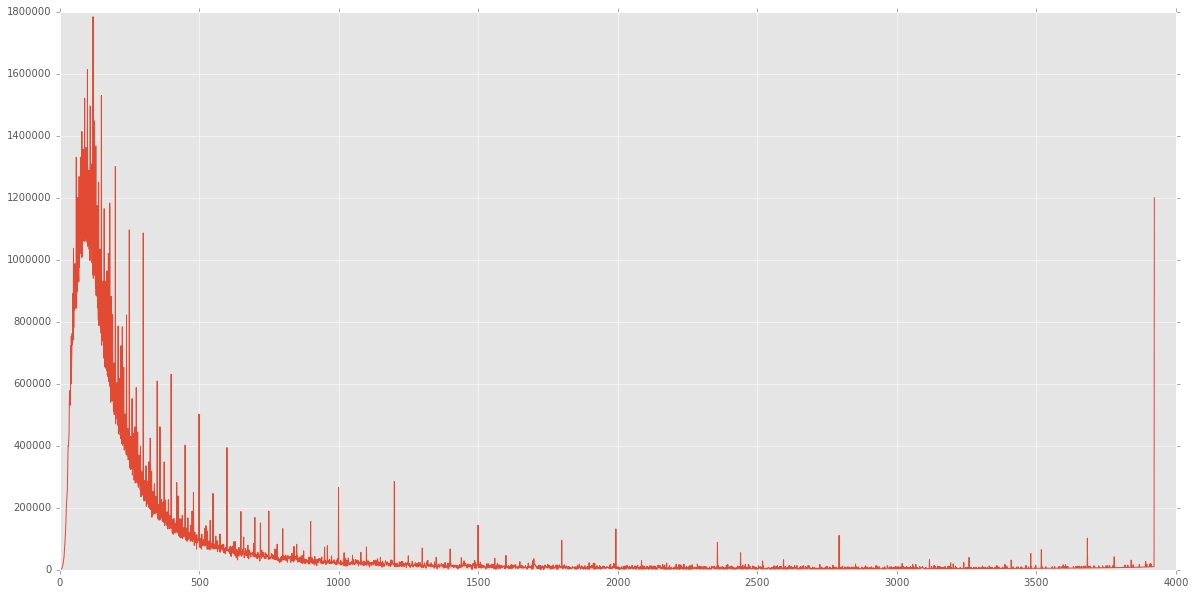

In [329]:
#plotting distributions of income
inc_fig = plt.figure(figsize=(20,10))
#x_tics = list(inc_2014.income)
y = inc_2014.amountXcount
#plt.xticks(range(len(x_tics)), x_ticks)
plt.plot(range(len(x_tics)), y)
plt.show(inc_fig)

549 549


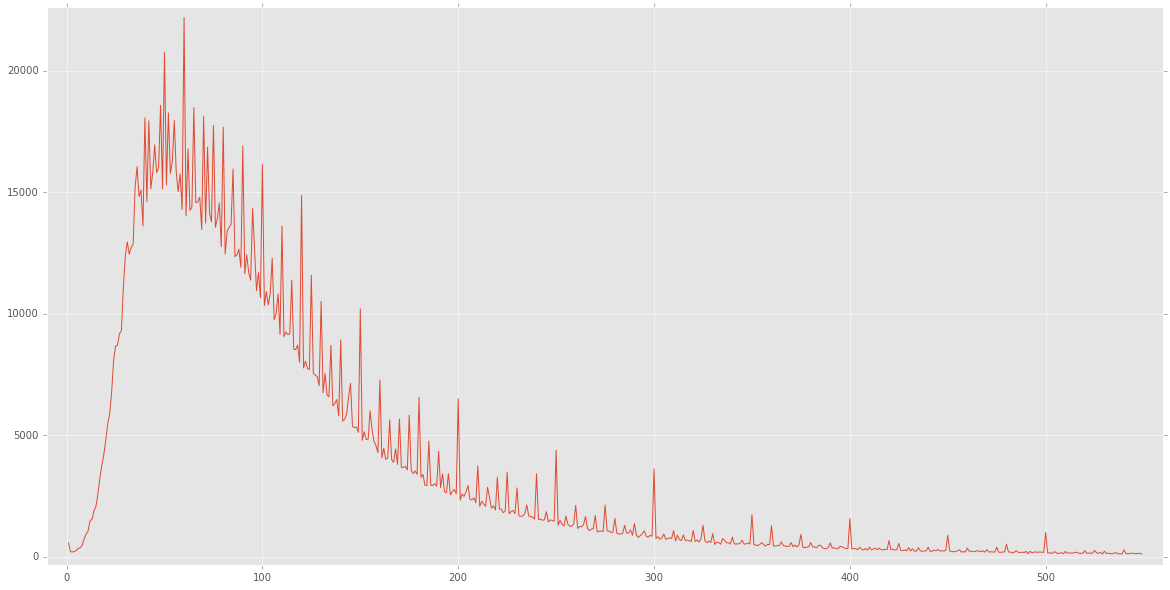

9999 1


In [348]:
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
#plotting distributions of income
inc_fig = plt.figure(figsize=(20,10))
x = list(inc_2014.income[inc_2014.income<550])
y = inc_2014['count'][inc_2014.income<550]

print(len(x), len(y))
#plt.xticks(np.arange(min(x), max(x)+1, 100))
plt.margins(0.02)
plt.plot(x, y)
plt.show(inc_fig)
print(inc_2014.income.max(), inc_2014.income.min())

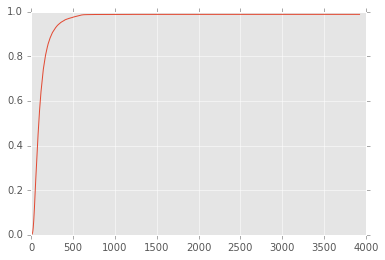

In [10]:
plt.plot(inc_2014.cumul_count_pct)



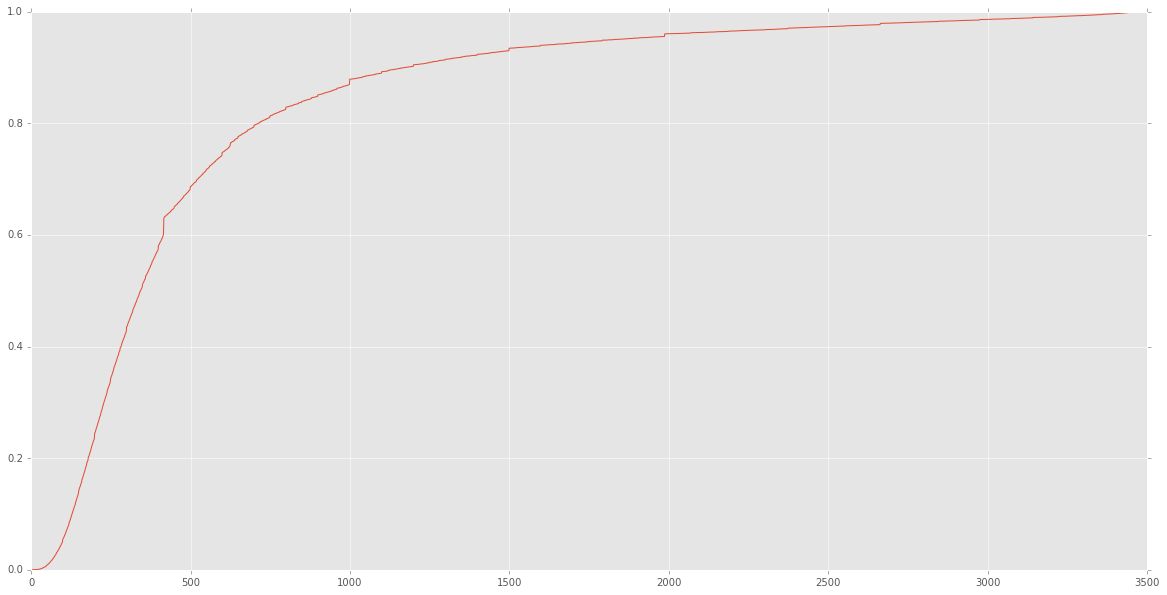

In [16]:
pct = plt.figure(figsize=(20,10))
plt.plot(dist_2014.cumul_vol_pct)
plt.show(pct)

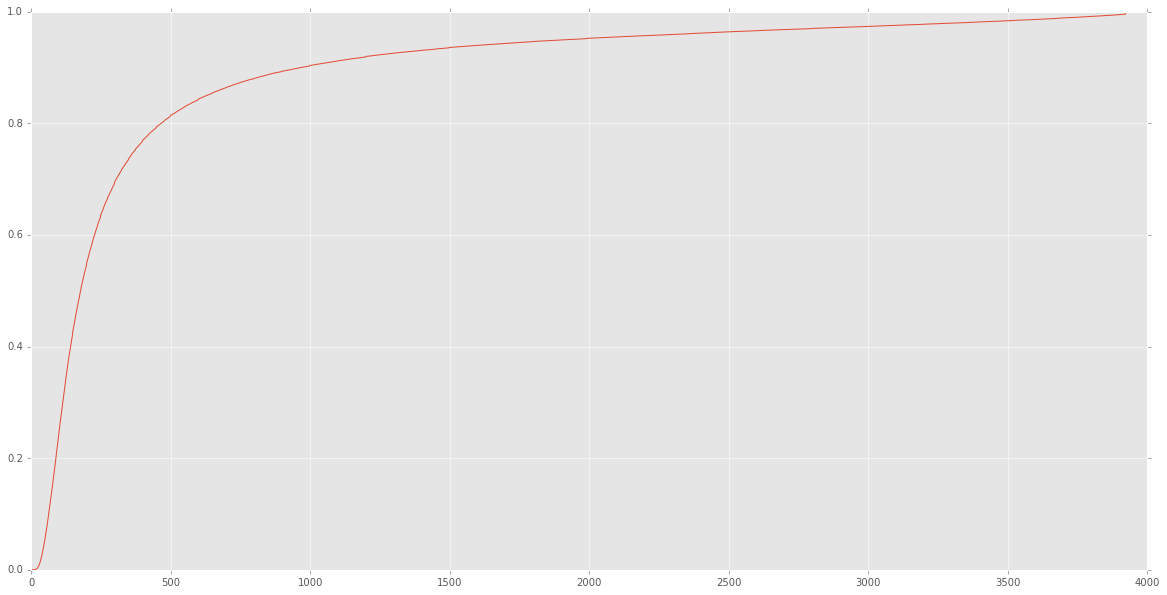

In [12]:
pct2 = plt.figure(figsize=(20,10))
plt.plot(inc_2014.cumul_vol_pct)
plt.show(pct2)

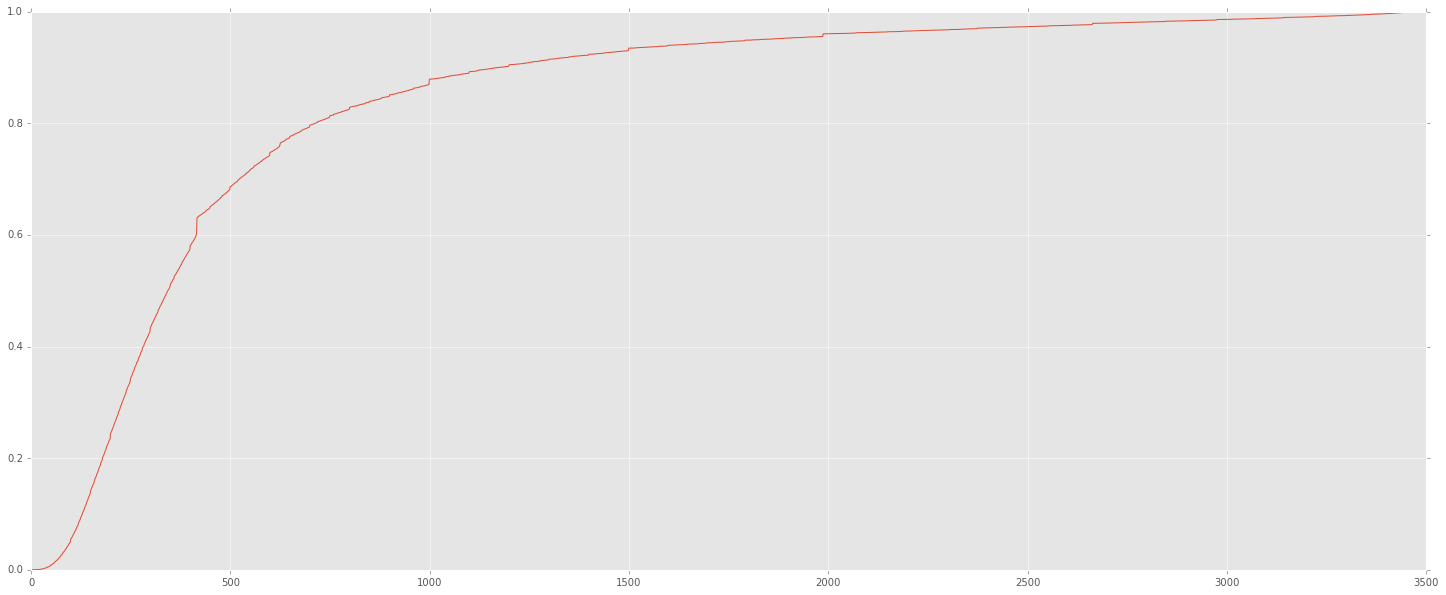

In [24]:
x = dist_2014.cumul_vol_pct
fig12 = plt.figure(figsize=(25,10))
#plt.xticks(np.arange(min(x), max(x)+1, 100))
plt.plot(x)
plt.show(fig12)

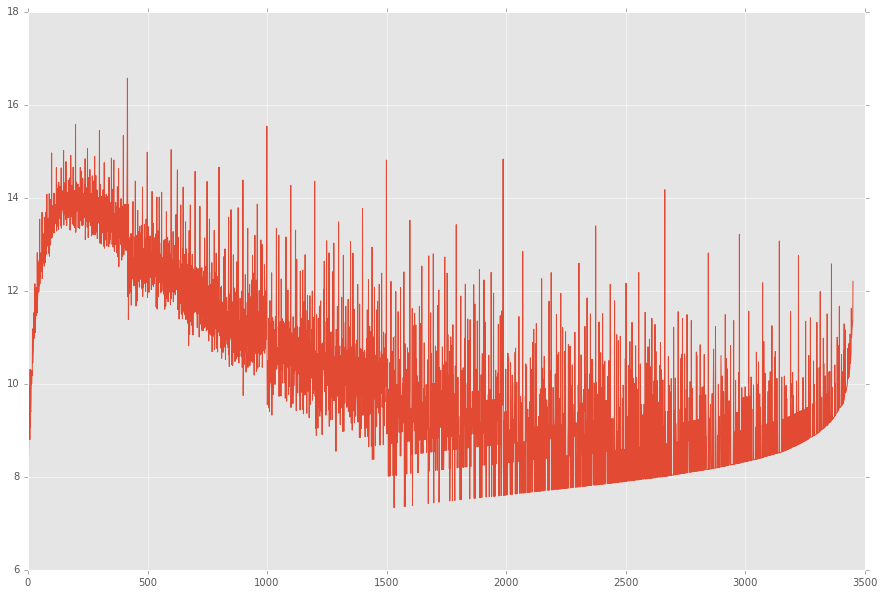

In [26]:
#x_ticks = list(dist_2014.amount)
fig = plt.figure(figsize=(15,10))
#plt.xticks(range(len(x_ticks)), x_ticks)
plt.plot(dist_2014.log)
plt.show(fig)

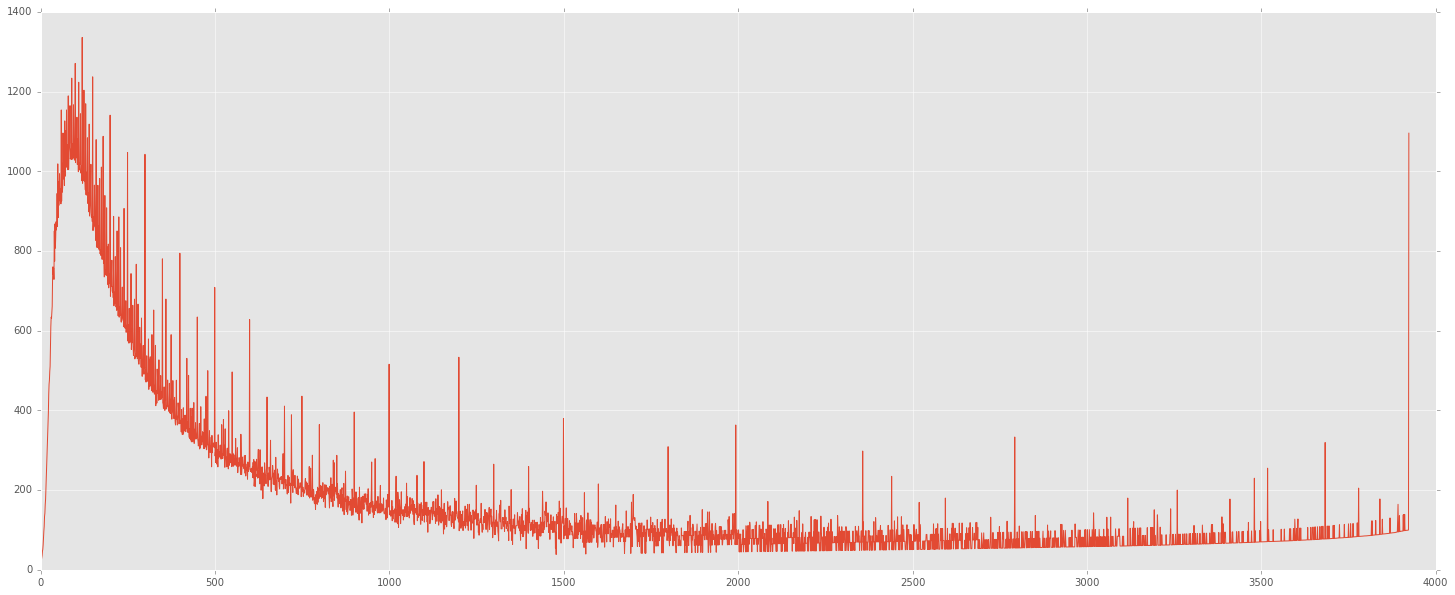

In [28]:
x_ticks = list(dist_2014.amount)

fig = plt.figure(figsize=(25,10))
#plt.xticks(range(len(x_ticks)), x_ticks)
plt.plot(inc_2014.sqrt)
plt.show(fig)

349    350
350    351
351    352
352    353
353    354
Name: income, dtype: int64


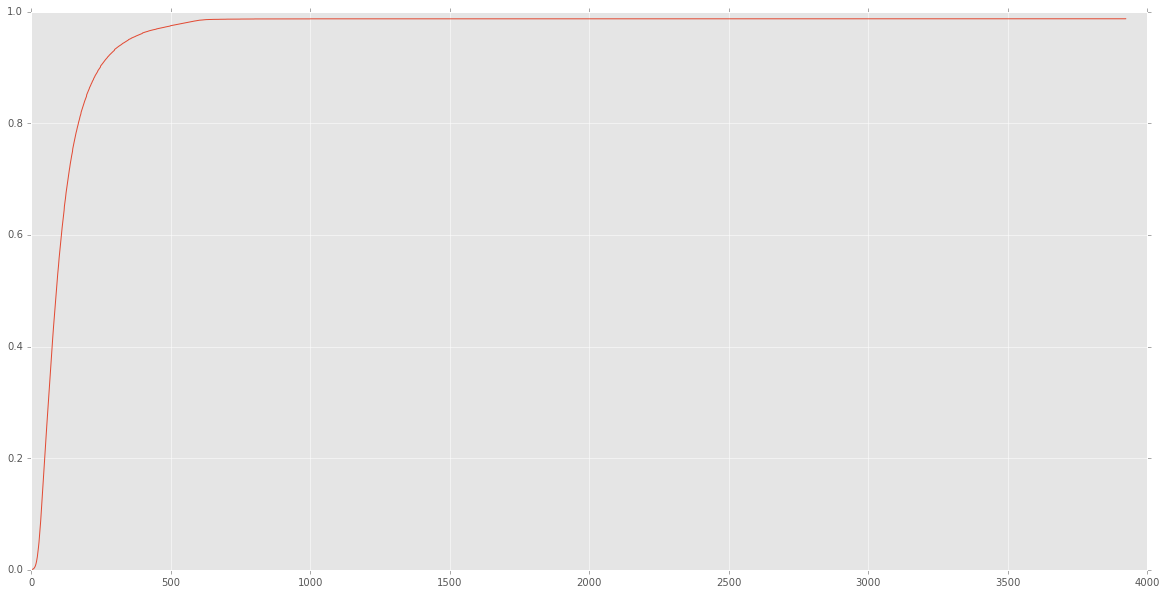

In [40]:
print(inc_2014.income[(inc_2014.cumul_count_pct > .95) & (inc_2014.cumul_count_pct <.951)])
fig = plt.figure(figsize = (20,10))
plt.plot(inc_2014.cumul_count_pct)

In [29]:
inc_2014

,year,income,count,amountXcount,pct_count,pct_inc,pct_volume,cumul_count_pct,cumul_inc_pct,cumul_vol_pct,log,sqrt
0,2014,1,574.0,574.0,0.0003,1.062022e-07,0.000002,0.0003,1.062022e-07,0.000002,6.352629,23.958297
1,2014,2,217.0,434.0,0.0001,2.124044e-07,0.000002,0.0004,3.186066e-07,0.000004,6.073045,20.832667
2,2014,3,202.0,606.0,0.0001,3.186066e-07,0.000002,0.0005,6.372131e-07,0.000006,6.406880,24.617067
3,2014,4,231.0,924.0,0.0001,4.248087e-07,0.000003,0.0006,1.062022e-06,0.000009,6.828712,30.397368
4,2014,5,259.0,1295.0,0.0001,5.310109e-07,0.000005,0.0007,1.593033e-06,0.000014,7.166266,35.986108
5,2014,6,362.0,2172.0,0.0002,6.372131e-07,0.000008,0.0009,2.230246e-06,0.000021,7.683404,46.604721
6,2014,7,376.0,2632.0,0.0002,7.434153e-07,0.000009,0.0011,2.973661e-06,0.000030,7.875499,51.303021
7,2014,8,488.0,3904.0,0.0002,8.496175e-07,0.000014,0.0013,3.823279e-06,0.000044,8.269757,62.481997
8,2014,9,749.0,6741.0,0.0004,9.558197e-07,0.000024,0.0017,4.779098e-06,0.000068,8.815964,82.103593
9,2014,10,938.0,9380.0,0.0004,1.062022e-06,0.000033,0.0021,5.841120e-06,0.000101,9.146335,96.850400
